In [1]:
import mxnet as mx
import random
import numpy as np
import gym
import time
import logging
import matplotlib.pyplot as plt
from memory import Memory
from mxnet import nd, autograd
from IPython import display
from collections import namedtuple
from model.simple_stack import SimpleStack

/home/seventheli/.local/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while

In [16]:
#Articheture
channel = 1
batch_size = 4
image_size = 84
#Trickes
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 100000
# With Freq of 1/4 step update the Q-network
learning_frequency = 4
# Skip N-1 raw frames between steps
skip_frame = 1
 # Skip N-1 raw frames between skipped frames
internal_skip_frame = 1
# Each state is formed as a concatination N step frames [f(t-4),f(t-3),f(t-2),f(t)]
frame_len = 4
# Update the target network each 10000 steps
Target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.1
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to backpropagated through the network, learning starts
replay_start_size = 5000
# Run uniform policy for first 5 times step of the beginning of the game
no_op_max = 10 / skip_frame
#otimization
num_episode = 10000000  # Number episode to run the algorithm
max_frame = 200000000
# RMSprop learning rate
lr = 0.001
# RMSprop gamma1
gamma1 = 0.95  
# RMSprop gamma2
gamma2 = 0.95
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()  

In [3]:
env_name = 'AssaultNoFrameskip-v4'
env = gym.make(env_name)
num_action = env.action_space.n
manualSeed = 1  # random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)

In [4]:
manualSeed = 1 # random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)

In [5]:
offline_model = SimpleStack(env.action_space.n, frame_len, channel=channel)
offline_model.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
offline_model.collect_params().zero_grad()

In [6]:
online_model = SimpleStack(env.action_space.n, frame_len, channel=channel)
online_model.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [7]:
trainer = mx.gluon.Trainer(offline_model.collect_params(), 'RMSProp',
                           {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})

In [8]:
def preprocess(raw_frame, channel_number=4, frame_num=4, currentState = None, initial_state = False):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = nd.reshape(nd.mean(raw_frame, axis = 2),shape = (raw_frame.shape[0],raw_frame.shape[1],1))
    raw_frame = mx.image.imresize(raw_frame,  image_size, image_size)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = raw_frame.astype('float32')/255.
    if initial_state == True:
        state = raw_frame
        for _ in range(opt.frame_len-1):
            state = nd.concat(state , raw_frame, dim = 0)
    else:
        state = mx.nd.concat(currentState[1:,:,:], raw_frame, dim = 0)
    return state, raw_frame


In [9]:
def rew_clipper(_):
    if _ > 0.:
        return 1.
    elif _ < 0.:
        return -1.
    else:
        return 0

In [10]:
def renderimage(next_frame):
    if render_image:
        plt.imshow(next_frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

### Initialize arrays

In [19]:
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size, frame_len=frame_len)
tot_reward = []
tot_clipped_reward = []
frame_count_record = []
cost = []
average_clipped = 0.
average = 0.

In [12]:
render_image = False  # Whether to render Frames and show the game

### Train the model

In [ ]:
batch_state = nd.empty((batch_size,frame_len,image_size,image_size), ctx)
batch_state_next = nd.empty((batch_size,frame_len,image_size,image_size), ctx)
batch_reward = nd.empty((batch_size), ctx)
batch_action = nd.empty((batch_size), ctx)
batch_done = nd.empty((batch_size), ctx)
batch_battery = nd.empty((batch_size), ctx)
while frame_counter < max_frame:
    initial_state = True
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state, current_frame = preprocess(next_frame, initial_state=initial_state)
    t = 0.
    done = False
    _t = time.time()
    while not done:
        mx.nd.waitall()
        previous_state = state
        # show the frame
        renderimage(next_frame)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print('annealing and laerning are started ')
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)
        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len, image_size, image_size]), ctx), nd.array([100], ctx)]
            action = int(nd.argmax(offline_model(data), axis=1).as_in_context(mx.cpu()).asscalar())
        # Skip frame
        frame_rewards = 0
        for skip in range(skip_frame-1):
            next_frame, reward, done, _ = env.step(action)
            renderimage(next_frame)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
            for internal_skip in range(internal_skip_frame-1):
                _ , reward, done,_ = env.step(action)
                cum_clipped_reward += rew_clipper(reward)
                frame_rewards += reward
        next_frame, reward, done, extra = env.step(action)
        extra = extra["lives"]
        renderimage(next_frame)
        cum_clipped_reward += rew_clipper(reward)
        frame_rewards += reward
        cum_reward += frame_rewards
        # Reward clipping
        reward = rew_clipper(frame_rewards)
        replay_memory.push((current_frame * 255.).astype(np.uint8), action, reward, done, extra, initial_state)
        state, current_frame = preprocess(next_frame, state)
        initial_state = False
        # Train
        if frame_counter > replay_start_size:
            if frame_counter % learning_frequency == 0:
                replay_memory.sample(batch_size,batch_state,batch_state_next,batch_reward,batch_action,batch_done, batch_battery)
                with autograd.record():
                    argmax_Q = nd.argmax(offline_model([batch_state_next, batch_battery]), axis=1).astype('uint8')
                    Q_sp = nd.pick(online_model([batch_state_next, batch_battery]), argmax_Q, 1)
                    Q_sp = Q_sp * (nd.ones(batch_size, ctx=ctx) - batch_done)
                    Q_s_array = offline_model([batch_state, batch_battery])
                    Q_s = nd.pick(Q_s_array, batch_action, 1)
                    loss = nd.mean(loss_f(Q_s, (batch_reward + gamma * Q_sp)))
                loss.backward()
                trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter > replay_start_size:
            if frame_counter % Target_update == 0:
                check_point = frame_counter / (Target_update * 100)
                fdqn = './data/model_%s_%d' % (env_name, int(check_point))
                offline_model.save_parameters(fdqn)
                online_model.load_parameters(fdqn, ctx)
                fnam = './data/clippted_rew_DDQN_%s' % (env_name)
                np.save(fnam, tot_clipped_reward)
                fnam = './data/tot_rew_DDQN_%s' % (env_name)
                np.save(fnam, tot_reward)
                fnam = './data/frame_count_DDQN_%s' % (env_name)
                np.save(fnam, frame_count_record)

        if done:
            cost.append(time.time() - _t)
            if epis_count % 10 == 0.:
                print('time cost=%d, epis=%d,eps=%.3f,durat=%d,fnum=%d, cum_cl_rew = %.3f, cum_rew = %.3f,tot_cl = %.3f , tot = %.3f'
                      % (np.mean(cost), epis_count, eps, t, frame_counter, cum_clipped_reward, cum_reward, average_clipped,average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record, frame_counter)
    
    if epis_count > 100.:
        average_clipped = np.mean(tot_clipped_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
        average = np.mean(tot_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
from tempfile import TemporaryFile

outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, average_clipped)

time cost=6, epis=0,eps=1.000,durat=2010,fnum=2010, cum_cl_rew = 17.000, cum_rew = 357.000,tot_cl = 0.000 , tot = 0.000
annealing and laerning are started 
time cost=42, epis=10,eps=0.982,durat=2362,fnum=22781, cum_cl_rew = 14.000, cum_rew = 294.000,tot_cl = 0.000 , tot = 0.000
time cost=47, epis=20,eps=0.963,durat=1369,fnum=41741, cum_cl_rew = 10.000, cum_rew = 210.000,tot_cl = 0.000 , tot = 0.000
time cost=49, epis=30,eps=0.942,durat=1882,fnum=62622, cum_cl_rew = 14.000, cum_rew = 294.000,tot_cl = 0.000 , tot = 0.000
time cost=50, epis=40,eps=0.922,durat=1882,fnum=83335, cum_cl_rew = 13.000, cum_rew = 273.000,tot_cl = 0.000 , tot = 0.000
time cost=51, epis=50,eps=0.900,durat=1497,fnum=104530, cum_cl_rew = 10.000, cum_rew = 210.000,tot_cl = 0.000 , tot = 0.000
time cost=52, epis=60,eps=0.877,durat=2329,fnum=127633, cum_cl_rew = 10.000, cum_rew = 210.000,tot_cl = 0.000 , tot = 0.000
time cost=53, epis=70,eps=0.855,durat=2433,fnum=150367, cum_cl_rew = 15.000, cum_rew = 315.000,tot_cl = 

### Plot the overall performace

Running after 300 number of episodes


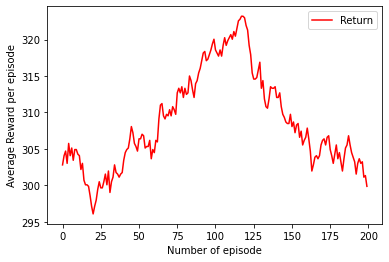

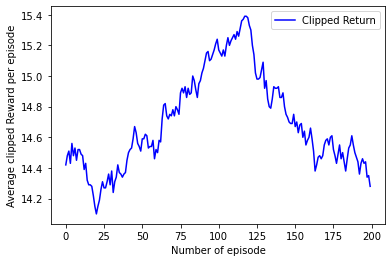

In [15]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth 
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN_Clipped.png')